# Machine Learning Project using Two Sigma connect data

The objective of this project is to predict the interest level in a listing, using the provided data.

In [106]:
import os
import pandas as pd
import numpy as np

#import data from folder
os.chdir('/Users/shintaromasuno/Desktop/kaggle/TwoSigma Connect House Prices/')


In [440]:
train_dat = pd.read_json('train.json')
train_dat.shape

(49352, 15)

In [161]:
train_dat.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [162]:
train_dat['interest_level'].value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

# Cast Categorical Interest Label into Numerical Value for Regression

We would like to predict the interest level for each listing, which currently has the following three categories: low, medium, and high. Since these categories are ordered, it would make sense to perform a regression after relabeling the categories into numbers. 

Set:
- low -> 0
- medium -> 0.5
- high -> 1

In order to perform the relabeling, I decided to define a custom sklearn transformer, which will make it easier to combine all these steps later in a pipeline.  

In [212]:
from sklearn.base import BaseEstimator, TransformerMixin 

# Dictionary for mapping interest levels into numerical values
cleanup_nums = {"low": 0, "medium": 0.5, "high": 1}

# Transformer for fixing categorical interest levels into numerical for regression purposes
class LabelInterestLevels(BaseEstimator, TransformerMixin):
    def __init__(self, num_dict): #no *args or **kargs
        self.num_dict = num_dict
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        interest_num_array = [self.num_dict[item] for item in X['interest_level']]
        return interest_num_array

# Initialize Interest Num and call constructor
interest_num = LabelInterestLevels(cleanup_nums)

# Create Pandas Dataframe with interest level numbers 
interest_num_arr = interest_num.fit_transform(train_dat)
interest_num_df = train_dat.copy()
interest_num_df['interest_numeric'] = interest_num_arr

Now I have the numeric labels for interest_level in a new column, with the name 'interest_numeric'.

In [214]:
interest_num_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_numeric
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,0.5
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,0.0
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,1.0
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,0.0
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,0.0


## Initial Trial -  Try out some simple models

I like to get right into modeling to see what accuracy can be achieved with a sample of the variables. Only using a subset of the entire training data (mostly the columns which are already in numerical format), I trained the following models:

- linear regression
- decision tree
- random forest

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Select Subset of Attributes
attributes = ['bathrooms','bedrooms','latitude','longitude','price']
X = train_copy[attributes]
y = train_copy['interest_level']

#Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg_pred = lin_reg.predict(X)

#Decision Tree
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X, y)
tree_reg_pred = tree_reg.predict(X)

#Random Forest
forest_reg = RandomForestRegressor()
forest_reg.fit(X, y)
forest_pred = forest_reg.predict(X)


## Evaluate Performance - Root Mean Squared Error

Calculating the RMSE to get an idea of the baseline performance. I'm not expecting great performance at this point. 

In [123]:
from sklearn.metrics import mean_squared_error

#Linear Regression RMSE
lin_mse = mean_squared_error(y, lin_reg_pred)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression:',lin_rmse)

#Decision Tree RMSE
tree_mse = mean_squared_error(y, tree_reg_pred)
tree_rmse = np.sqrt(tree_mse)
print('Decision Tree:', tree_rmse)

#Random Forest RMSE
forest_mse = mean_squared_error(y, forest_pred)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest:',forest_rmse)

Linear Regression: 0.310763400224
Decision Tree: 0.136235226675
Random Forest: 0.16428993383


# One Hot Encode the 'features' column

The 'features' column seems like it contains useful information about the rental property. I will do some analysis on this column.

In [353]:
import re

#Create a Set out of all the items in features column
category_set = set()

# Traverse each row in data for the 'features' column
for x in range(len(train_dat['features'])):
    temp_set = set(train_dat['features'].values[x])
    category_set = category_set.union(temp_set)

# Convert set to list and take out any irregular characters
category_list = list(category_set)

# Extracts all special characters
def take_out_irr_chars(x):
    return re.sub('[^\w]','',x)

# Take out all the irregular characters
#category_list = list(map(take_out_irr_chars, category_list))

Because each row in the data only contains the features particular to that listing (presented in a list), I have to traverse the entire data to count the number of unique features that appear in the data. From doing this, I realized that although there are 49,352 listings in the training data, there are only 1,556 unique features used to describe the listings. 

In [405]:
from sklearn.preprocessing import OneHotEncoder
feature_encoder = OneHotEncoder()

# Create DF to count number of times a feature shows
counter_df = pd.DataFrame(0, range(1), columns=category_list)

# Traverse features column to count how many times each feature appears 
for i in range(0, len(train_dat['features'])):
    temp_cat = train_dat['features'].values[i]
    if len(temp_cat) != 0:
        counter_df[temp_cat] = counter_df[temp_cat] + 1

# Sort counter array in descending order
word_count_desc = counter_df.sort_values(by=0,axis=1, ascending=False)

Below is the plot showing the number of times a feature shows up for each listing. It can be observed that a very small number of features make up for a very large number of appearances. For example, the most observed feature was 'Elevator' which appeared 25,915 times. The 200th most observed feature was 'hardwood floors' which was only observed 8 times across listings.   

In [442]:
word_count_desc.iloc[0,0:20]

Elevator               25915
Cats Allowed           23540
Hardwood Floors        23527
Dogs Allowed           22035
Doorman                20898
Dishwasher             20426
No Fee                 18062
Laundry in Building    16344
Fitness Center         13252
Pre-War                 9148
Laundry in Unit         8738
Roof Deck               6542
Outdoor Space           5268
Dining Room             5136
High Speed Internet     4299
Balcony                 2992
Swimming Pool           2730
Laundry In Building     2593
New Construction        2559
Terrace                 2283
Name: 0, dtype: int64

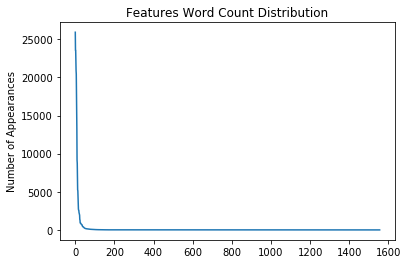

In [433]:
import matplotlib.pyplot as plt
%matplotlib inline

#word_count_desc.iloc[0]
plot1 = plt.plot(range(0,1556),word_count_desc.iloc[0])
plt.ylabel('Number of Appearances')
plt.title('Features Word Count Distribution')